# **Проект "Рыночная стоимость авто"**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

# **1. Вводная информация**

## **1.1. Задача**

Нам нужно построить модель для определения стоимости авто. 

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## **1.2. Описание набора данных**

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

## **1.3. План работы**

Коротко опишем наш пайплайн работы:

1. Загрузим и познакомимся с данными, оценим их качество и состояние;
2. Выполним необходимую предобработу данных;
3. Определим явные и скрытые взаимосвязи;
4. Определим признаки, которые лучше всего подходят для обучения;
5. Определим сетку параметров для поиска наиболее удачной модели;
6. Предварительное обучение и подбор параметров произведем для начала на небольшом количестве данных;
7. Проверим два основных варианта модели линейной регрессии и градиентного бустинга (LightGBM), а также ряд дополнительных моделей с улучшениями на основе этих. Чтобы усилить исследование, не ограничимся градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг.
8. Проанализируем и сравним характеристики моделей: точность предсказания, скорость работы и качество моделей.

Выбранная метрика для оценки качества: `RMSE`.


# **2. Настройка рабочего пространства**

## **2.1. Импорт библиотек и настройка рабочего пространства.**

In [290]:
from IPython.display import display, HTML 
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Any, Callable, Dict, Optional, Union

from phik import phik_matrix

from scipy.stats import ttest_ind, levene, bartlett, fligner

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score, precision_recall_curve

In [291]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
# %matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.3f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

## **2.2. Загрузка данных**

In [292]:
try:
    df = pd.read_csv('datasets/autos.csv')
    print("Данные загружены с домашнего компьютера")
except (FileNotFoundError, OSError):
    # Альтернативный путь для запуска из Интернета
    df = pd.read_csv('/datasets/autos.csv')
    print("Данные загружены из Интернета")

Данные загружены с домашнего компьютера


## **2.3. Деление данных на выборки**

In [293]:
# Разделение всего датафрейма
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

print(f'Train: {train_df.shape[0]} строк')
print(f'Test: {test_df.shape[0]} строк')

Train: 265776 строк
Test: 88593 строк


Для удобства итераций и предобработки создадим словарь датафреймов.

In [294]:
df_dict = {
            'train_df': train_df, 
            'test_df': test_df, 
            }

# **3. EDA: исследовательский анализ данных**

# **3.1. Оценка качества представленных данных**

In [295]:
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [296]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [297]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


## **3.2. Вывод о качестве данных**

**Качество данных УДОВЛЕТВОРИТЕЛЬНОЕ с серьезными проблемами**

**1. Аномальные значения и подозрительные значения:**

`Price`:  min=0, max=20000 (цена 0€ — явная ошибка)

`Power`: min=0, max=20000 (мощность 0 и 20000 л.с. — нереально)

`RegistrationYear`: min=1000, max=9999 (автомобили из 1000 и 9999 года — ошибка), двузначные отображения года (90), вероятно, тоже требуют внимания и коррекции.

`RegistrationMonth`: min=0 (месяц 0 не существует)

`Kilometer`: 75% значений = 150000 км (округление/ограничение)

`NumberOfPictures`: все значения = 0 (признак бесполезен)

**2. Пропуски данных:**

`VehicleType`: 37490 пропусков (10.6%)

`Gearbox`: 19833 пропусков (5.6%)

`Model`: 19705 пропусков (5.6%)

`FuelType`: 32895 пропусков (9.3%)

`Repaired`: 71154 пропусков (20.1%) — критично!

**3. Несогласованность:**

`Repaired` в датасете, но в описании `NotRepaired` (ПОЧЕМУ? инверсия логики?)

**4. Выбросы: как поступить с ними?**

- Удалять выбросы верно, если выброс - это шум или ошибка;

- удалять выброс нельзя если это редкое, но рельное событие.

Проблема в том, что могути попадаться машины или спорткары или коллекционные машины, или действиельно с большим или очень маленьким пробегом, и возхможно стоит соотносить с годом выпуска или попытаься определить релаьные пограничные значения.  

Если удалим выбросы при обучении:

- `LightGBM` → предсказания будут консервативными , но безопасными (будет использоваться максимально или минимально известное значение)

- `LinearRegression` → предсказания могут быть абсурдными (стоимость может оказаться отрицательное или в разы выше)



**Необходимые действия:**

- Удалить аномалии (Price <= 0, Power <= 0/20000, Year<1900/>2016, RegistrationMonth=0)

- Обработать пропуски (заполнение средним / удаление - проверить изменение качества модели)

- Проверить логику Repaired

- Исследовать распределение Kilometer

- Удалить `NumberOfPictures` (нулевая вариативность) и `DateCrawled`, `DateCreated`, `LastSeen` (технические даты)

**Вывод:** Данные требуют серьезной предобработки перед обучением модели.

## **3.3. Создание pipeline для предобработки**


Мы планируем использовать два варианта модели, в связи с чем будет отличать немного процесс предобработки.

- LinearRegression: нужна стандартизация (StandardScaler)

- LightGBM: стандартизация не нужна

Произведем предобработку данных на классах в PipeLine. Для этого создадим следующие классы:
- `DecimalPointChanger` - проверяет каждое значение столбца на наличие правильного разделителя дроби, в случае если будет найдена запята - заменит ее на точку;
- `OutlierRemover` - удалит выбросы;
- `ImplicitDuplicatesViewer` - отобразит список уникальных нечисловых значений каждого столбца, что должно помочь опредлелить неявные дубликаты в столбцах;
- `DuplicateRemover` - удалит явные дубликаты;
- `MissingValueHandler` - обрабатывает пропуски на основе выбранной стратегии, по умолчанию, удаляет всю строку, если есть в ней пропуск;
- `ColumnRemover` - удаляет лишний столбцы из датафрейма;
- `FloatToIntChanger` - преобразует дробное число в целочисленное.

Эти классы мы передадим в класс `EDAPreprocessor`, который станет основной состаляющей пайплайна EDA_Preprocessor_pipline, который будет производить предобработку данных. Зпуск пайплайна буддет вызываться функией  `run_preprocessor()`.

In [ ]:
class MistakeCorrector(BaseEstimator, TransformerMixin):
    """Класс для исправления ошибок в данных. Принимает опционально словарь с правильными значениями, список колонок, а также прямое указания действия в виде lambda функции."""
    def __init__(
            self, 
            columns: List[str], 
            values_dict: Optional[Dict[Any, Any]] = None, 
            func: Optional[Callable] = None,
            strategy: str = 'dict'
            ):
        
        """
        Инициализация исправителя ошибок.
        
        Parameters:
        - columns: список столбцов для обработки (обязательный)
        - values_dict: словарь {некорректное_значение: корректное_значение} (опционально)
        - func: функция для преобразования значений (например, lambda x: x * 10) (опционально)
        - strategy: стратегия обработки ('dict' или 'func'), по умолчанию 'dict'.
        """

        if not columns:
            raise ValueError("Параметр 'columns' не может быть пустым. Необходимо указать список столбцов, в которых проихзводить исправления значений")
            
        if strategy not in ['dict', 'func', 'auto']:
            raise ValueError("strategy должен быть 'dict' - для исправления значений по словарю, или 'func' - для определния метода вручную снаружи, например, lambda x: x * 10")

        self.values_dict = values_dict or {}
        self.columns = columns
        self.func = func
        self.strategy = strategy
        self.fill_values = {}  # ← для хранения вычисленных значений
    

    def fit(self, X: pd.DataFrame, y=None, **kwargs):
        if self.strategy == 'auto':
            for col in self.columns:
                for invalid_val, method in self.values_dict.items():
                    if method == 'median':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].median()
                    elif method == 'mode':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].mode()[0]
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        df = X.copy()
        
        for col in self.columns:
            if col not in df.columns:
                continue

            if self.strategy == 'auto':
                for invalid_val, method in self.values_dict.items():
                    mask = df[col] == invalid_val
                    if mask.any():
                        fill_val = self.fill_values[(col, invalid_val)]
                        print(f"- Заменено {mask.sum()} значений {invalid_val} в '{col}' на {fill_val:.0f} ({method})")
                        df.loc[mask, col] = fill_val
                        
            elif self.strategy == 'func' and self.func:
                df[col] = df[col].apply(self.func)
                
            elif self.strategy == 'dict' and self.values_dict:
                df[col] = df[col].replace(self.values_dict)
        
        return df

    def fit_transform(self, X, y: None = None, **fit_params):
        return self.fit(X, y).transform(X, y)

In [299]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах"""

    def __init__(self, columns: List[str]):
        """Инициализация заменщика дроби в строковых столбцах"""
        
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
    
    def fit_transform(self, X: Union[pd.DataFrame, np.array], y: None = None, **fit_params) -> np.ndarray:
        
        """Непосредственно заменяет разделитель дроби запятую на точку"""
        print('- Определяю необходимость замены запятой на точку')
        
        df = X.copy()

        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns

        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена не требуется')
        
        print('- Обработка завершена\n')
        return df

In [300]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Универсальный класс для обработки выбросов с винзоризацией"""

    def __init__(
        self,
        columns: Optional[List[str]] = None,
        method: str = 'IQR',
        action: str = 'winsorize',
        factor: float = 1.5,
        clip_quantiles: tuple = (0.01, 0.99),
        IQR_quantiles: tuple = (0.25, 0.75),
        extreme_factor: float = 3.0,
        min_valid_values: Optional[Dict[str, float]] = 1
    ):
        self.columns = columns
        self.method = method
        self.action = action
        self.factor = factor
        self.clip_quantiles = clip_quantiles
        self.IQR_quantiles = IQR_quantiles
        self.extreme_factor = extreme_factor
        self.min_valid_values = min_valid_values
        """
        Parameters:
        -----------
        columns: list of str optional, default=None (обрабатываются все числовые)
            Столбцы для обработки. Если None, обрабатываются все числовые столбцы.

        method: str, default='IQR'
            'IQR' или 'quantile'

        action: str, default='winsorize'
            'remove' (всю строку), 'nan', 'mean', 'clip' (замещение выбросов граничным значением), 'winsorize' (умная обработка)

        factor: float, default=1.5
            Множитель для IQR (только для IQR метода)    

        extreme_factor: float, default=3.0
            Множитель для экстремальных выбросов (только для winsorize)

        IQR_quantiles: tuple, default=(0.25, 0.75)
            Квантили для IQR метода

        clip_quantiles: tuple, default=(0.01, 0.99)
            Квантили для clip метода
        """

        self.columns = columns
        self.method = method
        self.action = action
        self.factor = factor
        self.extreme_factor = extreme_factor
        self.clip_quantiles = clip_quantiles
        self.IQR_quantiles = IQR_quantiles
        self.bounds_dict = {}                   # словарь с границами, который был создан в методе fit() выбросов может и не быть
        self.means_dict = {}

    def fit(self, X, y=None, **kwargs):
        """Запоминает границы"""
        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns
        
        if self.method == 'quantile':
            for col in cols:
                lower = X[col].quantile(self.clip_quantiles[0])
                upper = X[col].quantile(self.clip_quantiles[1])
                self.bounds_dict[col] = (lower, upper)
        else:  # IQR
            for col in cols:
                Q1 = X[col].quantile(self.IQR_quantiles[0])
                Q3 = X[col].quantile(self.IQR_quantiles[1])
                IQR = Q3 - Q1
                lower = Q1 - self.factor * IQR
                upper = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower, upper)
        
        if self.action == 'mean':
            for col in cols:
                self.means_dict[col] = X[col].mean()
        
        return self

    def transform(self, X):
        """Применяет обработку"""
        X_transformed = X.copy()
        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns


        # Этот код не ищет выбросы — он просто проверяет, есть ли выбросы в каждой колонке.
        # Чтобы Вывести предупреждение ниже, в каких колонках найдены выбросы
        outlier_cols = []
        for col in cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return X_transformed
        
        print(f'- Обнаружены выбросы в столбцах: {outlier_cols}')
        print(f'- Метод: {self.method}, Действие: {self.action}\n')

        # ВЫВОД ГРАНИЦ ДЛЯ КАЖДОЙ КОЛОНКИ
        for col in outlier_cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                print(f'  Нормальные пределы для {col}: [{lower:.2f} - {upper:.2f}]')
        print()
        
        # ВИНЗОРИЗАЦИЯ (умная обработка)
        if self.action == 'winsorize':
            print('- Применяю винзоризацию (мягкие → clip, экстремальные → remove)')
            X_transformed['outlier_status'] = 'normal'
            
            for col, (lower, upper) in self.bounds_dict.items():
                # Границы для экстремальных выбросов
                IQR = upper - lower
                extreme_lower = lower - self.extreme_factor * IQR
                extreme_upper = upper + self.extreme_factor * IQR
                
                # Мягкие выбросы → винзоризация (clipping)
                mild_outliers = ((X_transformed[col] < lower) & (X_transformed[col] >= extreme_lower)) | \
                               ((X_transformed[col] > upper) & (X_transformed[col] <= extreme_upper))
                X_transformed.loc[mild_outliers, 'outlier_status'] = 'mild'
                X_transformed.loc[mild_outliers, col] = X_transformed.loc[mild_outliers, col].clip(lower, upper)
                
                # Экстремальные выбросы → маркировка для удаления
                extreme_outliers = (X_transformed[col] < extreme_lower) | (X_transformed[col] > extreme_upper)
                X_transformed.loc[extreme_outliers, 'outlier_status'] = 'extreme'
            
            # Удаляем только экстремальные
            n_extreme = (X_transformed['outlier_status'] == 'extreme').sum()
            if n_extreme > 0:
                print(f'Удалено экстремальных выбросов: {n_extreme}')
                X_transformed = X_transformed[X_transformed['outlier_status'] != 'extreme']
            
            X_transformed = X_transformed.drop('outlier_status', axis=1)
        
        # Остальные действия (clip, nan, mean, remove)
        elif self.action == 'clip':
            for col, (lower, upper) in self.bounds_dict.items():
                X_transformed[col] = X_transformed[col].clip(lower, upper)
        
        elif self.action == 'nan':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = np.nan
        
        elif self.action == 'mean':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = self.means_dict[col]
        
        elif self.action == 'remove':
            if self.columns is None:
                mask = pd.Series([True] * len(X_transformed), index=X_transformed.index)
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    mask &= ~outliers
                X_transformed = X_transformed[mask]
            else:
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    X_transformed = X_transformed[~outliers]

        # Удаление физически невозможных значений (например, возраст < 0 или пробег > 1000000, пробег < 0, цена < 0 и т.д.)
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in X_transformed.columns:
                    invalid_mask = X_transformed[col] < min_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{self.bounds_dict[col][0]:.2f} - {max_invalid:.2f}]")
                        print(f"   Минимально допустимое значение: {min_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]
        
        return X_transformed


In [301]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов"""

    def __init__(self, columns: List[str] = None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах')

        df = X.copy()

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {X[col].unique()}\n')
            return X
        else: 
            # columns = X.select_dtypes(exclude=[np.number]).columns # проверить только нечисловвые ячейки
            for col in df.columns:
                print(f'- Уникальные значения в столбце {col}: {X[col].unique()}\n')
            return X
        
    def fit_transform(self, X, y: None = None, **fit_params):
        return self.fit(X, y).transform(X)

In [302]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов"""

    def __init__(self, columns: List[str] = None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None):
        """Удаляет дубликаты"""
        
        duplicate_count = X.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                X = X.drop_duplicates(subset=self.columns)                
            else:
                X = X.drop_duplicates()
            
            remaining_duplicates = X.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')
        else:
            print('- Дубликатов не выявлено\n')
        
        return X  # ← теперь возвращаешь очищенный X

    
    def fit_transform(self, X, y: None = None, **fit_params):
        return self.fit(X, y).transform(X)

In [303]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных. Возможные варианты параметра strategy: mean, median, mode, drop, unknown. По умолчанию drop"""

    def __init__(self, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit(self, X: pd.DataFrame, y: None=None):
        """Формальное объявление"""
        return self
        
    def transform(self, X: pd.DataFrame, y: None = None, **fit_params):
        """Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        
        df = X.copy()
        
        if self.strategy == 'mean':
            for col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f"- В колонке '{col}' {df[col].isnull().sum()} пропусков. Заполняю средним\n")
            self.fill_values_ = df.select_dtypes(include=[np.number]).mean().to_dict() # словарь средних значений для каждого числового столбца

        elif self.strategy == 'median':
            for col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f"- В колонке '{col}' {df[col].isnull().sum()} пропусков. Заполняю медианой\n")
            self.fill_values_ = df.select_dtypes(include=[np.number]).median().to_dict()

        elif self.strategy == 'mode':
            self.fill_values_ = {}
            for col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f"- В колонке '{col}' {df[col].isnull().sum()} пропусков. Заполняю модой\n")
                self.fill_values_[col] = df[col].value_counts().index[0]

        elif self.strategy == 'unknown':
            self.fill_values_ = {}
            for col in df.select_dtypes(include='object').columns:
                if df[col].isnull().sum() > 0:
                    print(f"- В колонке '{col}' {df[col].isnull().sum()} пропусков. Заполняю значением 'unknown'\n")
                    self.fill_values_[col] = 'unknown'

        elif self.strategy == 'drop':
            null_count = df.isna().sum().sum()
            if null_count > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                null_string_count = len(df[df.isna().any(axis=1)])
                display(df[df.isna().any(axis=1)])
                if len(df[df.eq(" ").any(axis=1)]) != 0:
                    display(df[df.eq(" ").any(axis=1)])
                
                null_string_percentage = null_string_count / len(df) * 100
                if null_string_percentage < 10:
                    print(f'- Выявлено {null_count} пропусков в {null_string_count} строках, что составляет {null_string_percentage:.2f}% от таблицы.  Выполняю удаление строк с пропущенными значениями\n')
                    df = df.dropna()
                    df = df[~df.eq(" ").any(axis=1)]  # удаляет пустые пробелы типа пропуск
                    if df.isna().sum().sum() == 0:
                        print('- Пропусков не осталось.\n')
                    else:
                        print(f'- {df.isna().sum().sum()} пропусков осталось.\n')
                    return df
            else:
                print('- Пропусков не найдено\n')

        for col, fill_value in self.fill_values_.items():
             if col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f'- В колонке {col} {df[col].isnull().sum()} пропусков. Заполняю пропуски на {self.strategy}\n')
                    df[col] = df[col].fillna(fill_value)

        return df

    def fit_transform(self, X: pd.DataFrame, y: None = None, **fit_params):
        return self.fit(X, y).transform(X)
        

In [304]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    """Удаляет лишние колонки, переданные в списке""" 

    def __init__(self, columns: List[str]):
        self.columns = columns

    def fit(self, X: pd.DataFrame, y: None=None):
        # Просто сохраняем информацию о столбцах для удаления
        return self

    def transform(self, X: pd.DataFrame):

        df = X.copy()

        for col in self.columns:
            if col in df.columns:
                df = df.drop(col, axis=1)
                print(f'- Удалил столбец {col}')
        return df

    def fit_transform(self, X: pd.DataFrame, y: None=None, **fit_params):
        return self.fit(X, y).transform(X)

In [305]:
class FloatToIntChanger(BaseEstimator, TransformerMixin):
    """
    Преобразует дробные значения в целочисленные (режим Multiplie - по умолчанию: 
    умножает на 100 и сохраняет как Int, simple: без умножения меняет тип) на основе переданного списка столбцов
    """    

    def __init__(self, columns, strategy):
        self.columns = columns
        self.strategy = strategy


    def fit(self, X: pd.DataFrame, y=None):
        # Просто сохраняем информацию о столбцах формально
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            # Если на входе массив, генерируем имена колонок
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self
    

    def transform(self, X: pd.DataFrame):

        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            # Восстанавливаем DataFrame из массива
            df = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.strategy == 'simple':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Меняю тип на int столбце {col}')
                    df = df[col].astype('int')
            return df

        if self.strategy == 'multiplie':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Значения в столбце {col} умножаю на 100 ')
                    df[col] = (df[col] * 100).astype('int')
                else:
                    print(f'- Колонка {col} не найдена в данных')
            return df

    def fit_transform(self, X: pd.DataFrame, y=None, **fit_params):
        return self.fit(X, y).transform(X)

In [306]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self, func: Callable[..., Any] | None = None):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        
    def add_mistake_corrector(
                                self, 
                                columns: List[str] | None = None,
                                values_dict: dict | None = None, 
                                func: Callable[..., Any] | None = None, 
                                strategy: str | None = None, 
                                step_name: str =' Преобразование некорректных данных'):
        """Добавляет шаг исправления ошибок в препроцессор, принимает на вход список колонок, в которых произвести замены, словарь с неверными и верными значениями"""
        
        mistake_corrector = MistakeCorrector(
                                                columns=columns, 
                                                values_dict=values_dict, 
                                                func=func,
                                                strategy=strategy
            )
        self.steps.append((step_name, mistake_corrector))
        return self

    def add_column_remover(
            self, 
            columns: List[str], 
            step_name: str = 'Удаление столбцов'):
        
        column_remover=ColumnRemover(columns)
        self.steps.append((step_name, column_remover))
        return self

    def add_float_to_int_changer(
            self, 
            columns:List[str] | None = None,
            strategy='multiplie', 
            step_name='Преобразование дробных чисел в целочисленное'):
        float_to_int_changer=FloatToIntChanger(columns, strategy)
        self.steps.append((step_name, float_to_int_changer))
        return self

    def add_decimal_point_changer(
            self, 
            columns:List[str] | None = None, 
            step_name='Замена запятой на точку в дробных числах при необходимости'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(
            self, 
            strategy='drop', 
            fill_value=None, 
            step_name='Проверка пропущенных значений'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        missing_handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, missing_handler))
        return self    


    def add_outlier_handler(
            self, 
            columns: Optional[List[str]] = None,
            method: str = 'IQR',
            action: str = 'winsorize',
            factor: float = 1.5,
            extreme_factor: float = 3.0,
            min_valid_values: Optional[Dict[str, float]] = None,
            step_name: str = 'Проверка на наличие выбросов'):
        '''Добавляет шаг обработки выбросов'''
        outlier_handler = OutlierHandler(
            columns=columns,
            method=method,
            action=action,
            factor=factor,
            extreme_factor=extreme_factor,
            min_valid_values=min_valid_values
        )
        self.steps.append((step_name, outlier_handler))
        return self

 
    
    def add_drop_duplicates(
            self, 
            step_name='Проверка на наличие явных дубликатов'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover()
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(
            self, 
            columns:List[str] | None = None, 
            step_name='Отображение неявных дубликатов и проверка на неоднородность данных'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer(columns=columns)
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, X: pd.DataFrame, name, y: None=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        df = X.copy()

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'\nИсполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name=name)
            self.fitted_transformers[step_name] = transformer

        return df

In [ ]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_mistake_corrector(
        columns=['RegistrationMonth'],
        values_dict={0: 'median'},
        strategy='auto'
        )
    .add_column_remover(
        columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures']
        )
    .add_decimal_point_changer()                            # проверяет наличие запятой в дробном чисе если найдет заменит на точку
    .add_outlier_handler(                                   # обрабатывает выбросы только в определенных столбцах, тестовую выборку пропустит
        method='IQR',
        action='remove',
        factor=1.5,
        extreme_factor=3.0,
        min_valid_values={
        'Price': 1, 
        'Power': 1,
        # 'RegistrationYear': 1900  
        }
        )                                  
    .add_missing_value_handler(                             # Обработка пропусков
        strategy='unknown'
        )           
    .add_drop_duplicates()                                  # проверяет строки дубликаты
    .add_implicit_duplicates_viewer(columns=None)           # выводит уникальные значения для определения неявных дуликатов
    # .add_float_to_int_changer(strategy='multiplie', columns=[])
)

print('Вот таким у нас получился предобработчик данных.\n')

print("Шаги в пайплайне:\n")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот таким у нас получился предобработчик данных.

Шаги в пайплайне:

1. Удаление столбцов: ColumnRemover(columns=['DateCrawled', 'DateCreated', 'LastSeen',
                       'NumberOfPictures'])

2. Замена запятой на точку в дробных числах при необходимости: DecimalPointChanger(columns=None)

3. Проверка на наличие выбросов: OutlierHandler(action='remove', min_valid_values={'Power': 1, 'Price': 1})

4. Проверка пропущенных значений: MissingValueHandler(strategy='unknown')

5. Проверка на наличие явных дубликатов: DuplicateRemover()

6. Отображение неявных дубликатов и проверка на неоднородность данных: ImplicitDuplicatesViewer()



In [308]:
def run_preprocessor(df_dict=df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(df_dict[name].head())

run_preprocessor(df_dict)

 =>  Обработка датафрейма train_df

Исполнение шага 1: Удаление столбцов
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 2: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth замена не требуется
- В столбце FuelType замена не требуется
- В столбце Brand замена не требуется
- В столбце Repaired замена не требуется
- В столбце PostalCode замена не требуется
- Обработка завершена


Исполнение шага 3: Проверка на наличие выбросов
- Обнаружены выбросы в столбцах: ['Price', 'RegistrationYear', 'Power', 'Kilometer']
- Метод: IQR, Действи

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
257527,1650,sedan,1999,manual,122,c_klasse,125000,10,petrol,mercedes_benz,no,26382
46203,800,wagon,1997,manual,144,v70,150000,7,petrol,volvo,no,57612
27435,850,wagon,1999,manual,101,golf,150000,1,petrol,volkswagen,no,45329
51334,4600,suv,2000,manual,179,other,150000,9,gasoline,audi,no,92723
200771,3500,small,2005,manual,54,polo,150000,7,petrol,volkswagen,unknown,27432


 =>  Обработка датафрейма test_df

Исполнение шага 1: Удаление столбцов
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 2: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth замена не требуется
- В столбце FuelType замена не требуется
- В столбце Brand замена не требуется
- В столбце Repaired замена не требуется
- В столбце PostalCode замена не требуется
- Обработка завершена


Исполнение шага 3: Проверка на наличие выбросов
- Обнаружены выбросы в столбцах: ['Price', 'RegistrationYear', 'Power', 'Kilometer']
- Метод: IQR, Действие

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
212563,2850,wagon,2001,manual,131,passat,150000,9,gasoline,volkswagen,no,38259
109307,50,small,1996,manual,60,corsa,150000,8,petrol,opel,yes,7957
248545,500,unknown,2016,manual,82,a_klasse,150000,2,petrol,mercedes_benz,unknown,49356
47677,850,unknown,2016,manual,55,astra,150000,12,petrol,opel,no,14656
337147,7999,small,2011,manual,99,500,90000,5,petrol,fiat,no,71272


In [309]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174475 entries, 257527 to 131932
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              174475 non-null  int64 
 1   VehicleType        174475 non-null  object
 2   RegistrationYear   174475 non-null  int64 
 3   Gearbox            174475 non-null  object
 4   Power              174475 non-null  int64 
 5   Model              174475 non-null  object
 6   Kilometer          174475 non-null  int64 
 7   RegistrationMonth  174475 non-null  int64 
 8   FuelType           174475 non-null  object
 9   Brand              174475 non-null  object
 10  Repaired           174475 non-null  object
 11  PostalCode         174475 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 17.3+ MB


In [310]:
train_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,174475.000,174475.000,174475.000,174475.000,174475.000,174475.000
mean,3528.700,2002.660,115.361,142399.140,5.913,51020.335
std,3184.294,5.885,44.452,16374.182,3.629,25694.123
min,1.000,1986.000,1.000,90000.000,0.000,1067.000
25%,1100.000,1999.000,75.000,150000.000,3.000,30880.000
50%,2450.000,2002.000,110.000,150000.000,6.000,49699.000
75%,4999.000,2006.000,143.000,150000.000,9.000,71566.000
max,14400.000,2019.000,250.000,150000.000,12.000,99998.000


### **3.5. Классификация признаков по типам**

Перед построением распределений признаков и обучений модели необходимо классифицировать их по способу обработки, а не по математической классификации: 

- **числовые**, 
- **категориальные**

**1. Числовые** — используются как есть:

- `RegistrationYear` — непрерывный

- `Power` — непрерывный

- `Kilometer` — дискретный (но обрабатывается как непрерывный)

- `RegistrationMonth` — дискретный

- `PostalCode` — числовой (но может быть категориальным, регион влияет на цену, но 99к уникальных значений, можно агрегировать)

**2. Категориальные** — требуют кодирования:

- `VehicleType` — номинальный (sedan, suv, coupe...)

- `Gearbox` — номинальный (manual, auto)

- `Model` — номинальный (golf, passat...)

- `FuelType` — номинальный (petrol, diesel...)

- `Brand` — номинальный (volkswagen, audi...)

- `Repaired` — бинарный (yes/no)

**Обработка:**

`LinearRegression`: OneHotEncoder (создает бинарные столбцы)

`LightGBM`: OrdinalEncoder или передать как categorical_feature (LightGBM сам обработает)

Разделим признаки на группы:

## **3.6. Оценка распределения признаков**

Распределение показывает, как предобработать данные и какие трансформации применить перед обучением модели.

Зачем смотреть распределение признаков:

**1. Выявление аномалий и выбросов**

- `Цена` = 0€ или Power = 20000 л.с. — явные ошибки

- `Год` = 1000 или 9999 — нереальные значения

**2. Выбор метода обработки**

- Нормальное распределение → StandardScaler для LinearRegression

- Скошенное распределение → логарифмирование или RobustScaler

- Равномерное → MinMaxScaler

**3. Понимание данных**

- Если 75% `Kilometer` = 150000 → признак малоинформативен (ограничение платформы)

- Если `Price` сильно скошен вправо → много дешевых авто, мало дорогих

**4. Выбор признаков**

- Бимодальное распределение → возможно, есть скрытые группы (премиум/эконом)

**5. Трансформации для модели**

- `LinearRegression` чувствительна к масштабу → нужна нормализация

- Логарифм цены может улучшить предсказание (если распределение логнормальное)

**6. Проверка качества данных**

- Все значения округлены до 5000? → данные агрегированы

- Пики на определенных значениях? → возможно, заполнение пропусков константой

### **3.6.1. Распределение бинарных признаков**

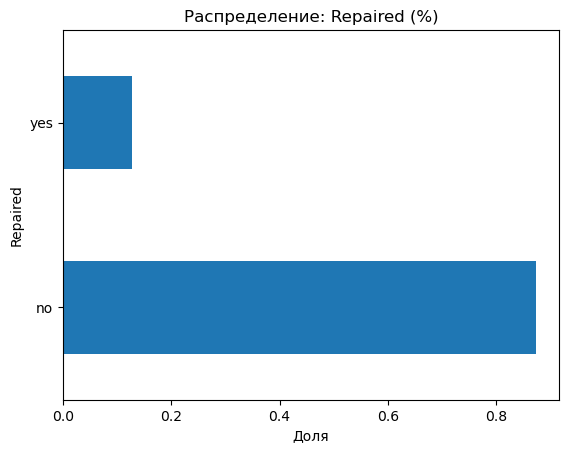

In [311]:
# Визуализация бинарных признаков: столбчатая диаграмма с двумя цветами и процентами
df['Repaired'].value_counts(normalize=True).plot.barh()
plt.title('Распределение: Repaired (%)')
plt.xlabel('Доля')
plt.show()


### **3.6.2. Распределение числовых признаков**

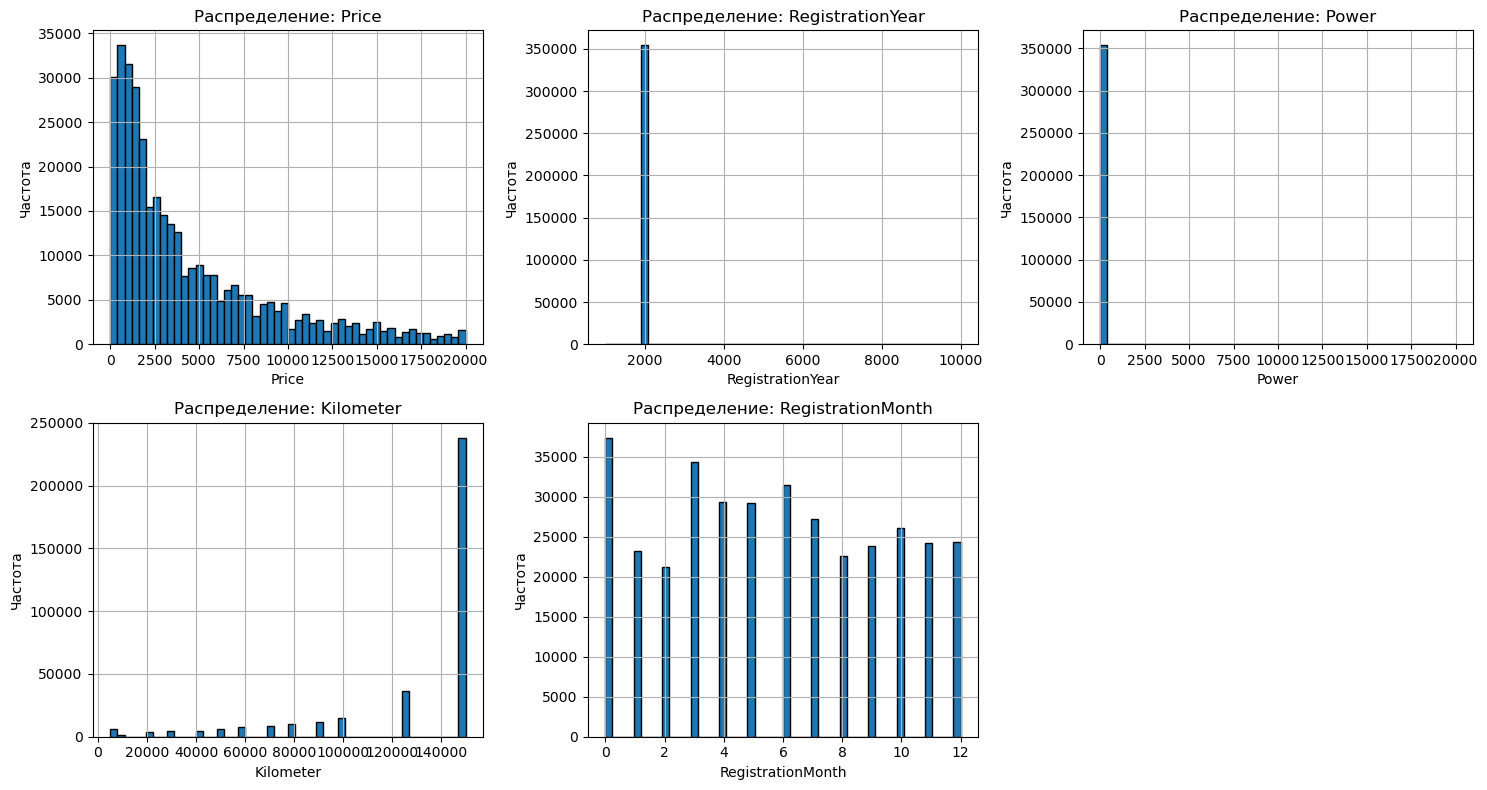

In [312]:
# Распределение числовых признаков
numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    df[col].hist(bins=50, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

axes[-1].axis('off')  # Скрыть последний пустой график
plt.tight_layout()
plt.show()

### **3.6.4. Распределение категориальных признаков**

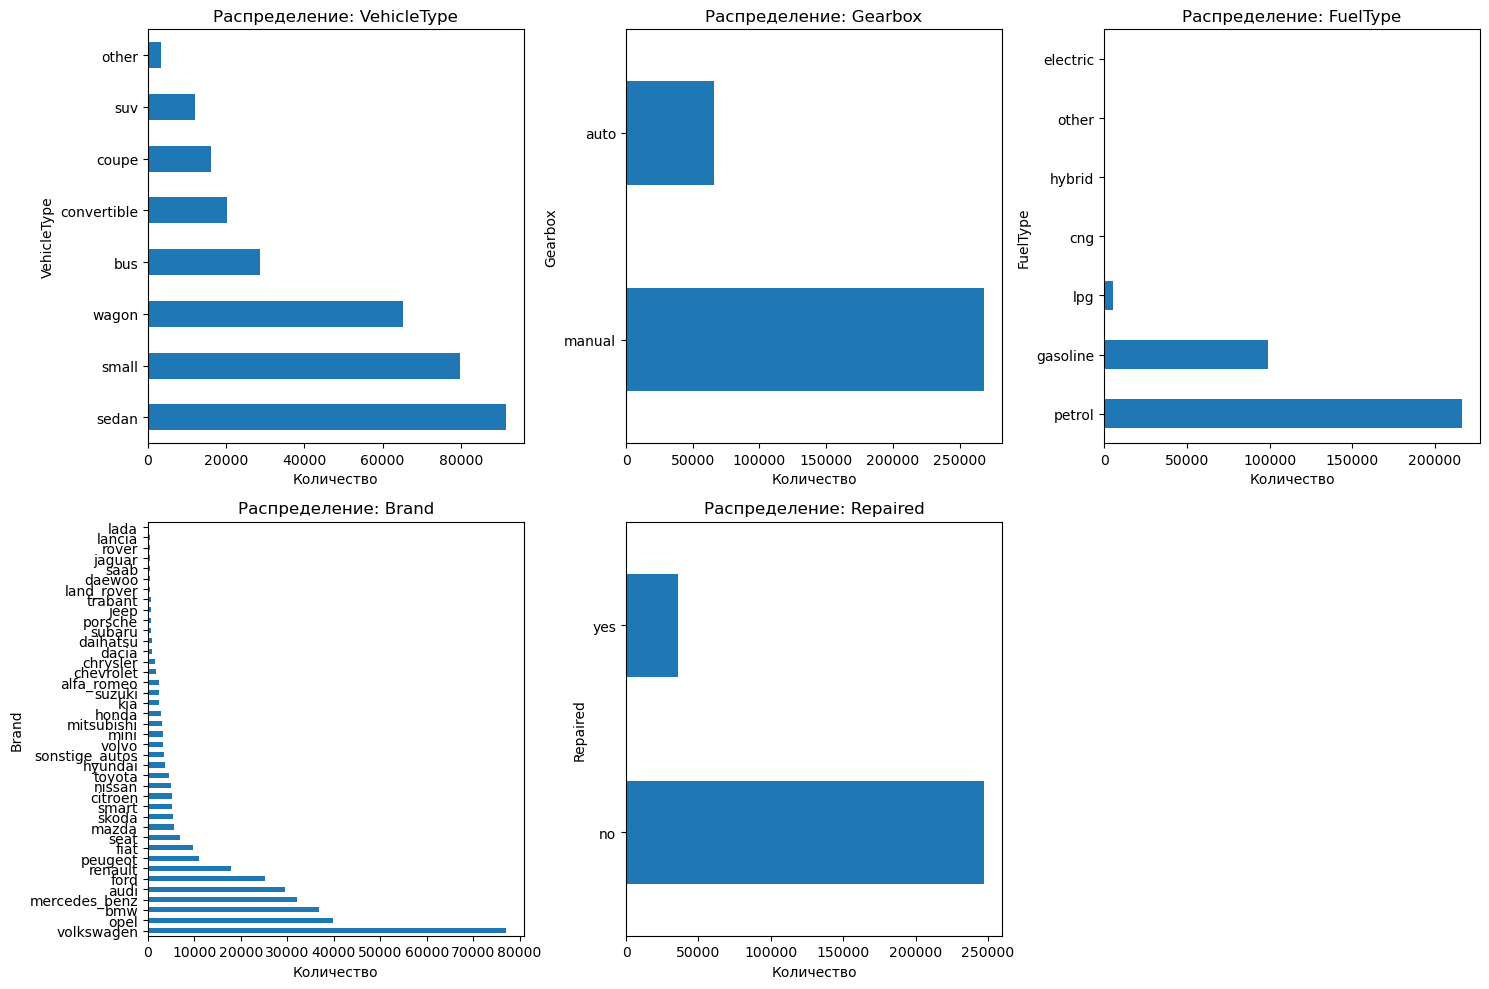

In [313]:
# Визуализация категориальных признаков
# Распределение категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    df[col].value_counts().plot.barh(ax=axes[i])
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel('Количество')

axes[-1].axis('off')
plt.tight_layout()
plt.show()



In [314]:

# Непрерывные признаки для phik_matrix (interval_cols)
continuous_features = ['Power']  # только мощность — истинно непрерывная

# Или можно добавить:
continuous_features = ['Power', 'RegistrationYear']  # если год считать непрерывным

## **3.7. Расшифровка оценки описательной статитистики и распределения значений признаков**

## **3.8. Корреляция данных**

In [315]:
interval_cols = feature_types['continuous'] # только дробные числа, или которые не в силах посчитать руками и может иметь друбную часть (если очень много значений, значит интервальный тип)

phik_corr = train_df.phik_matrix(interval_cols=interval_cols)
phik_corr     

NameError: name 'feature_types' is not defined

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
sns.pairplot(df)

## **3.10. Проверка данных на неоднородность: выявление нелинейных связей**

Мы надеемся, что выявление скрытых связей поможет повысить качество обучения.

**Мы применим:**

1. **Тесты Левена и Бартлетта** для проверки однородности дисперсий; 
2. **Simpson's Paradox:** когда общая корреляция и внутри груцппы имеют противопаоложные знаки;
3. Группировочный анализ;
4. Стабильность корреляций;
5. Скрытые кластеры;
6. Нелинейные связи;
7. Взаимодействия.

#### **3.10.1. Тесты Левена и Бартлетта**

Проверим однородность дисперсий. 

В искусственных данных, дисперсии в двух подгруппах (1/0) будут либо одинаковые либо резко разные.

Функция проверяет однородность дисперсий между группами для выявления неоднородности данных.

**Что делает:**

- Для каждой группирующей колонки (например, Gender, Diabetes) разбивает данные на подгруппы

- Для каждого числового признака применяет два статистических теста:

- Тест Левена — проверяет равенство дисперсий (устойчив к отклонениям от нормальности)

- Тест Бартлетта — также проверяет равенство дисперсий (чувствителен к нормальности распределения)

- Возвращает p-значения тестов и флаг heteroscedastic (неоднородность дисперсий), если p < 0.05

**Зачем**: Если дисперсии в группах различаются (гетероскедастичность), это указывает на неоднородность данных — разные подгруппы ведут себя по-разному, что может объяснить отсутствие общих корреляций в ваших данных.

In [ ]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Масштабирование
    ('model', LinearRegression())
])